### Choice of pytorch

* Easy to use
* Dynamic gestion of the computational graph
* Well used in research
* Good documentation


In [1]:
# Import module
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from copy import deepcopy
from itertools import product
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from train_tools import TrainHelper

In [2]:
# load data
TRAIN_DATASET = "./../data/csv/mnist_train.csv"
TEST_DATASET = "./../data/csv/mnist_test.csv"


def load_data(filename):
    """Load the data of the file given in parameter."""
    
    data = np.loadtxt(filename, delimiter=",")
    train = np.asfarray(data[:, 1:])
    labels = np.reshape(data[:, :1], -1)

    print("> {} loaded".format(filename.split("/")[-1]))
    
    return train, labels

# TODO: Ask if we can use the mnist dataset given by pytorch

# Load the training and the test set.
training_data, training_labels = load_data(TRAIN_DATASET)
test_data, test_labels = load_data(TEST_DATASET)

> mnist_train.csv loaded
> mnist_test.csv loaded


In [3]:
# split the training set in 2. The training set 85% and the validation set 15%.

# TODO: ask if we have to perform a cross validation because the dataset is big enough to not necessarily need
#       to do a cross validation for the validation step.
size_train = int(training_data.shape[0]*0.85)
size_val = training_data.shape[0]-size_train

indices = np.random.permutation(training_data.shape[0])
train_idx, val_idx = indices[:size_train], indices[size_train:]

train_data, val_data = training_data[train_idx,:], training_data[val_idx,:]
train_labels, val_labels = training_labels[train_idx], training_labels[val_idx]

In [4]:
# Create MnistDataset
class MnistDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target
        
    def __getitem__(self, index):
        datapoint = self.data[index]
        target = self.target[index]
        return torch.tensor(datapoint, dtype=torch.float),\
               torch.tensor(target, dtype=torch.long)
    
    def __len__(self):
        return len(self.data)

In [5]:
batch_size = 32
    
# Create dataset
train_dataset = MnistDataset(train_data, train_labels)
val_dataset = MnistDataset(val_data, val_labels)
test_dataset = MnistDataset(test_data, test_labels)

# Create data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
class NeuralNetwork(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, input_):
        return self.layers(input_)


In [7]:
def plot_graph(nb_epochs, train, val, step):
    plt.figure()
    plt.plot(np.arange(nb_epochs), train)
    plt.plot(np.arange(nb_epochs), val)
    plt.legend(['training', 'validation'])
    plt.xlabel('epoch')
    plt.ylabel(f'{step} value')
    plt.title(f'Train/val {step}');
        
    plt.show()

Hidden dim: 10, learning rate: 0.1
Train_loss: 2.302 |                Val_loss: 2.302 |                Train_acc: 11.261 |                Val_acc: 10.333
Hidden dim: 10, learning rate: 0.01
Train_loss: 2.097 |                Val_loss: 2.201 |                Train_acc: 19.125 |                Val_acc: 19.689
Hidden dim: 10, learning rate: 0.001
Train_loss: 0.974 |                Val_loss: 1.429 |                Train_acc: 69.167 |                Val_acc: 55.300
Hidden dim: 20, learning rate: 0.1
Train_loss: 2.302 |                Val_loss: 2.302 |                Train_acc: 11.220 |                Val_acc: 10.967
Hidden dim: 20, learning rate: 0.01
Train_loss: 2.301 |                Val_loss: 2.301 |                Train_acc: 11.284 |                Val_acc: 10.967
Hidden dim: 20, learning rate: 0.001
Train_loss: 0.238 |                Val_loss: 0.301 |                Train_acc: 93.184 |                Val_acc: 91.978
Hidden dim: 30, learning rate: 0.1
Train_loss: 2.302 |                

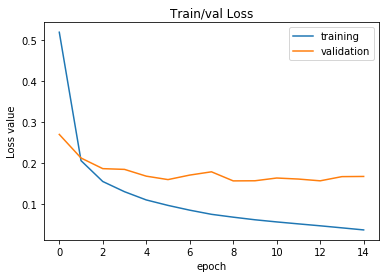

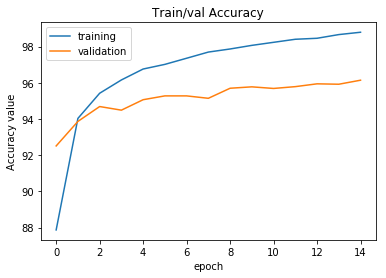

In [8]:
input_dim = 28*28
hidden_dims = [i for i in range(10, 101, 10)]
output_dim = 10
l_rates = [1*10**-i for i in range(1, 4)]
nb_epochs = 15
trainer = TrainHelper(nb_epochs)

# best parameters: (validation acc, hidden dim, learning rate)
best_parameters = (float("-INF"), None, None, None)
# keep a copy of the best trained network
best_model = None

loss_function = nn.CrossEntropyLoss()

for hidden_dim, l_rate in product(hidden_dims, l_rates):
    neural_net = NeuralNetwork(input_dim, hidden_dim, output_dim)
    optimizer = torch.optim.SGD(neural_net.parameters(), l_rate)
    
    
    print(f'Hidden dim: {hidden_dim}, learning rate: {l_rate}')
    stats_training = trainer.fit(neural_net,
                                 train_loader,
                                 val_loader,
                                 optimizer,
                                 loss_function)
    
    if stats_training[3][-1] > best_parameters[0]:
        best_parameters = (stats_training[3][-1], hidden_dim, l_rate, stats_training)
        best_model = deepcopy(neural_net)

best_acc, best_hidden_dim, best_l_rate, best_stats = best_parameters
train_losses, val_losses, train_accuracies, val_accuracies = best_stats

print(f'\n\nBest parameters: {best_hidden_dim} hidden dim, \
{best_l_rate} learning_rate and validation accuracies: {best_acc:.2f}%')

plot_graph(nb_epochs, train_losses, val_losses, "Loss")
plot_graph(nb_epochs, train_accuracies, val_accuracies, "Accuracy")

In [9]:
# Create dataset with full training set for training the final model
train_full_dataset = MnistDataset(training_data, training_labels)
train_full_loader = DataLoader(train_full_dataset, batch_size=batch_size, shuffle=True)

# Train model with the best parameters
best_neural_net = NeuralNetwork(input_dim, best_hidden_dim, output_dim)
best_optimizer = torch.optim.SGD(best_neural_net.parameters(), best_l_rate)
loss_function = nn.CrossEntropyLoss()

for _ in range(nb_epochs):
    trainer.train(best_neural_net, train_full_loader, best_optimizer, loss_function)

In [10]:
loss_test, acc_test = trainer.validation(best_neural_net, test_loader, loss_function)
print(f'Accuracy on the test dataset {acc_test:.2f}%')

Accuracy on the test dataset 96.66%
